# Testing Sigmoid Function by John Houghton

In [93]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def multiplier(x):
    return x * 2

In [94]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(100,1), columns=['random'])
df['sigmoid'] = df['random'].apply(sigmoid)
df['random2'] = df['random'].apply(multiplier)
df['sigmoid2'] = df['random2'].apply(sigmoid)
df.head()

,random,sigmoid,random2,sigmoid2
0,0.998137,0.730692,1.996275,0.880405
1,-0.627076,0.348174,-1.254151,0.221982
2,-1.410525,0.196151,-2.821051,0.056197
3,-1.754269,0.147510,-3.508538,0.029070
4,0.390750,0.596463,0.781500,0.686003


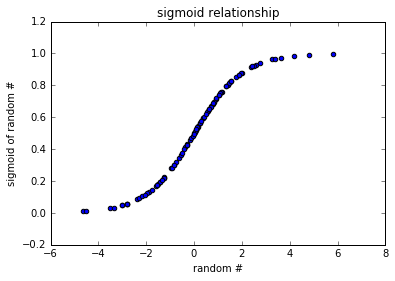

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.scatter(df['random2'], df['sigmoid2'])
plt.title('sigmoid relationship')
plt.ylabel('sigmoid of random #')
plt.xlabel('random #')
plt.show()

In [80]:
# sigmoid calculator
sigmoid(1)

0.7310585786300049

# Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with existing GraphLab functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use SFrames to do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Let's get started!
    
## Fire up GraphLab Create

Make sure you have the latest version of GraphLab Create.

In [1]:
from __future__ import division
import graphlab
import math
import string

# Data preparation

We will use a dataset consisting of baby product reviews on Amazon.com.

In [2]:
products = graphlab.SFrame('amazon_baby.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1507169676.log


This non-commercial license of GraphLab Create for academic use is assigned to johnkirkhoughton1@gmail.com and will expire on April 06, 2018.


Now, let us see a preview of what the dataset looks like.

In [96]:
products

name,review,rating
Planetwise Flannel Wipes,"These flannel wipes areOK, but in my opinion ...",3.0
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0


## Build the word count vector for each review

Let us explore a specific example of a baby product.


In [ ]:
products[269]

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://www.cis.upenn.edu/~treebank/tokenization.html) for an example of smart handling of punctuations.

In [97]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

review_without_punctuation = products['review'].apply(remove_punctuation)
products['word_count'] = graphlab.text_analytics.count_words(review_without_punctuation)

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

In [98]:
products[269]['word_count']

{'a': 1, 'favorite': 1, 'house': 1, 'in': 1, 'our': 1}

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [99]:
products = products[products['rating'] != 3]
len(products)

166752

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [ ]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [ ]:
train_data, test_data = products.random_split(.8, seed=1)
print len(train_data)
print len(test_data)

# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will use `validation_set=None` to obtain same results as everyone else.

**Note:** This line may take 1-2 minutes.

In [ ]:
sentiment_model = graphlab.logistic_classifier.create(train_data,
                                                      target = 'sentiment',
                                                      features=['word_count'],
                                                      validation_set=None)

In [ ]:
sentiment_model

**Aside**. You may get a warning to the effect of "Terminated due to numerical difficulties --- this model may not be ideal". It means that the quality metric (to be covered in Module 3) failed to improve in the last iteration of the run. The difficulty arises as the sentiment model puts too much weight on extremely rare words. A way to rectify this is to apply regularization, to be covered in Module 4. Regularization lessens the effect of extremely rare words. For the purpose of this assignment, however, please proceed with the model above.

Now that we have fitted the model, we can extract the weights (coefficients) as an SFrame as follows:

In [ ]:
weights = sentiment_model.coefficients
weights.column_names()

There are a total of `121713` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

Fill in the following block of code to calculate how many *weights* are positive ( >= 0). (**Hint**: The `'value'` column in SFrame *weights* must be positive ( >= 0)).

In [ ]:
num_positive_weights = ...
num_negative_weights = ...

print "Number of positive weights: %s " % num_positive_weights
print "Number of negative weights: %s " % num_negative_weights

**Quiz Question:** How many weights are >= 0?

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [ ]:
sample_test_data = test_data[10:13]
print sample_test_data['rating']
sample_test_data

Let's dig deeper into the first row of the **sample_test_data**. Here's the full review:

In [ ]:
sample_test_data[0]['review']

That review seems pretty positive.

Now, let's see what the next row of the **sample_test_data** looks like. As we could guess from the sentiment (-1), the review is quite negative.

In [ ]:
sample_test_data[1]['review']

We will now make a **class** prediction for the **sample_test_data**. The `sentiment_model` should predict **+1** if the sentiment is positive and **-1** if the sentiment is negative. Recall from the lecture that the **score** (sometimes called **margin**) for the logistic regression model  is defined as:

$$
\mbox{score}_i = \mathbf{w}^T h(\mathbf{x}_i)
$$ 

where $h(\mathbf{x}_i)$ represents the features for example $i$.  We will write some code to obtain the **scores** using GraphLab Create. For each row, the **score** (or margin) is a number in the range **[-inf, inf]**.

In [ ]:
scores = sentiment_model.predict(sample_test_data, output_type='margin')
print scores

### Predicting sentiment

These scores can be used to make class predictions as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w}^T h(\mathbf{x}_i) > 0 \\
      -1 & \mathbf{w}^T h(\mathbf{x}_i) \leq 0 \\
\end{array} 
\right.
$$

Using scores, write code to calculate $\hat{y}$, the class predictions:

Run the following code to verify that the class predictions obtained by your calculations are the same as that obtained from GraphLab Create.

In [ ]:
print "Class predictions according to GraphLab Create:" 
print sentiment_model.predict(sample_test_data)

**Checkpoint**: Make sure your class predictions match with the one obtained from GraphLab Create.

### Probability predictions

Recall from the lectures that we can also calculate the probability predictions from the scores using:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))}.
$$

Using the variable **scores** calculated previously, write code to calculate the probability that a sentiment is positive using the above formula. For each row, the probabilities should be a number in the range **[0, 1]**.

**Checkpoint**: Make sure your probability predictions match the ones obtained from GraphLab Create.

In [ ]:
print "Class predictions according to GraphLab Create:" 
print sentiment_model.predict(sample_test_data, output_type='probability')

** Quiz Question:** Of the three data points in **sample_test_data**, which one (first, second, or third) has the **lowest probability** of being classified as a positive review?

# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use GraphLab Create to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews."

To calculate these top-20 reviews, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data, use option `output_type='probability'` to output the probability rather than just the most likely class.)
2.  Sort the data according to those predictions and pick the top 20. (**Hint:** You can use the `.topk` method on an SFrame to find the top k rows sorted according to the value of a specified column.)

**Quiz Question**: Which of the following products are represented in the 20 most positive reviews? [multiple choice]


Now, let us repeat this exercise to find the "most negative reviews." Use the prediction probabilities to find the  20 reviews in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**.

**Quiz Question**: Which of the following products are represented in the 20 most negative reviews?  [multiple choice]

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [ ]:
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    ## YOUR CODE HERE
    ...
    
    # Compute the number of correctly classified examples
    ## YOUR CODE HERE
    ...

    # Then compute accuracy by dividing num_correct by total number of examples
    ## YOUR CODE HERE
    ...
    
    return accuracy

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [ ]:
get_classification_accuracy(sentiment_model, test_data, test_data['sentiment'])

**Quiz Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Quiz Question**: Does a higher accuracy value on the **training_data** always imply that the classifier is better?

## Learn another classifier with fewer words

There were a lot of words in the model we trained above. We will now train a simpler logistic regression model using only a subset of words that occur in the reviews. For this assignment, we selected a 20 words to work with. These are:

In [ ]:
significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
      'work', 'product', 'money', 'would', 'return']

In [ ]:
len(significant_words)

For each review, we will use the **word_count** column and trim out all words that are **not** in the **significant_words** list above. We will use the [SArray dictionary trim by keys functionality]( https://dato.com/products/create/docs/generated/graphlab.SArray.dict_trim_by_keys.html). Note that we are performing this on both the training and test set.

In [ ]:
train_data['word_count_subset'] = train_data['word_count'].dict_trim_by_keys(significant_words, exclude=False)
test_data['word_count_subset'] = test_data['word_count'].dict_trim_by_keys(significant_words, exclude=False)

Let's see what the first example of the dataset looks like:

In [ ]:
train_data[0]['review']

The **word_count** column had been working with before looks like the following:

In [ ]:
print train_data[0]['word_count']

Since we are only working with a subset of these words, the column **word_count_subset** is a subset of the above dictionary. In this example, only 2 `significant words` are present in this review.

In [ ]:
print train_data[0]['word_count_subset']

## Train a logistic regression model on a subset of data

We will now build a classifier with **word_count_subset** as the feature and **sentiment** as the target. 

In [ ]:
simple_model = graphlab.logistic_classifier.create(train_data,
                                                   target = 'sentiment',
                                                   features=['word_count_subset'],
                                                   validation_set=None)
simple_model

We can compute the classification accuracy using the `get_classification_accuracy` function you implemented earlier.

In [ ]:
get_classification_accuracy(simple_model, test_data, test_data['sentiment'])

Now, we will inspect the weights (coefficients) of the **simple_model**:

In [ ]:
simple_model.coefficients

Let's sort the coefficients (in descending order) by the **value** to obtain the coefficients with the most positive effect on the sentiment.

In [ ]:
simple_model.coefficients.sort('value', ascending=False).print_rows(num_rows=21)

**Quiz Question**: Consider the coefficients of **simple_model**. There should be 21 of them, an intercept term + one for each word in **significant_words**. How many of the 20 coefficients (corresponding to the 20 **significant_words** and *excluding the intercept term*) are positive for the `simple_model`?

**Quiz Question**: Are the positive words in the **simple_model** (let us call them `positive_significant_words`) also positive words in the **sentiment_model**?

# Comparing models

We will now compare the accuracy of the **sentiment_model** and the **simple_model** using the `get_classification_accuracy` method you implemented above.

First, compute the classification accuracy of the **sentiment_model** on the **train_data**:

Now, compute the classification accuracy of the **simple_model** on the **train_data**:

**Quiz Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TRAINING set?

Now, we will repeat this exercise on the **test_data**. Start by computing the classification accuracy of the **sentiment_model** on the **test_data**:

Next, we will compute the classification accuracy of the **simple_model** on the **test_data**:

**Quiz Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set?

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [ ]:
num_positive  = (train_data['sentiment'] == +1).sum()
num_negative = (train_data['sentiment'] == -1).sum()
print num_positive
print num_negative

Now compute the accuracy of the majority class classifier on **test_data**.

**Quiz Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

**Quiz Question**: Is the **sentiment_model** definitely better than the majority class classifier (the baseline)?